#Breast Cancer Detaction using PySpark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz

In [ ]:
!tar xf /content/spark-3.3.2-bin-hadoop3.tgz

In [ ]:

!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

In [ ]:
import findspark
findspark.init()

In [ ]:
findspark.find()

'/content/spark-3.3.2-bin-hadoop3'

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
spark

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('/content/ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels

--2023-04-09 17:31:18--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.237.133.81, 54.161.241.46, 52.202.168.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.237.133.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  49.1MB/s    in 0.3s    

2023-04-09 17:31:18 (49.1 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
{"tunnels":[],"uri":"/api/tunnels"}


#dataset import

In [ ]:
df = spark.read.csv('/content/drive/MyDrive/dataset/Bigdata/Breast_cancer_prediction.csv', inferSchema=True, header=True)
df.dtypes

[('mean_radius', 'double'),
 ('mean_texture', 'double'),
 ('mean_perimeter', 'double'),
 ('mean_area', 'double'),
 ('mean_smoothness', 'double'),
 ('diagnosis', 'int')]

#dataset structure and description

In [ ]:
df.printSchema()

root
 |-- mean_radius: double (nullable = true)
 |-- mean_texture: double (nullable = true)
 |-- mean_perimeter: double (nullable = true)
 |-- mean_area: double (nullable = true)
 |-- mean_smoothness: double (nullable = true)
 |-- diagnosis: integer (nullable = true)



In [ ]:
df.columns

['mean_radius',
 'mean_texture',
 'mean_perimeter',
 'mean_area',
 'mean_smoothness',
 'diagnosis']

In [ ]:
df.show(5)

+-----------+------------+--------------+---------+---------------+---------+
|mean_radius|mean_texture|mean_perimeter|mean_area|mean_smoothness|diagnosis|
+-----------+------------+--------------+---------+---------------+---------+
|      17.99|       10.38|         122.8|   1001.0|         0.1184|        0|
|      20.57|       17.77|         132.9|   1326.0|        0.08474|        0|
|      19.69|       21.25|         130.0|   1203.0|         0.1096|        0|
|      11.42|       20.38|         77.58|    386.1|         0.1425|        0|
|      20.29|       14.34|         135.1|   1297.0|         0.1003|        0|
+-----------+------------+--------------+---------+---------------+---------+
only showing top 5 rows



In [ ]:
df.describe().show()

+-------+------------------+-----------------+-----------------+-----------------+--------------------+------------------+
|summary|       mean_radius|     mean_texture|   mean_perimeter|        mean_area|     mean_smoothness|         diagnosis|
+-------+------------------+-----------------+-----------------+-----------------+--------------------+------------------+
|  count|               569|              569|              569|              569|                 569|               569|
|   mean|14.127291739894563|19.28964850615117|91.96903339191566|654.8891036906857|   0.096360281195079|0.6274165202108963|
| stddev|3.5240488262120793|4.301035768166948| 24.2989810387549|351.9141291816529|0.014064128137673616|0.4839179564031685|
|    min|             6.981|             9.71|            43.79|            143.5|             0.05263|                 0|
|    max|             28.11|            39.28|            188.5|           2501.0|              0.1634|                 1|
+-------+-------

In [ ]:
df.count()

569

In [ ]:
df.select("mean_radius","diagnosis").show(5)

+-----------+---------+
|mean_radius|diagnosis|
+-----------+---------+
|      17.99|        0|
|      20.57|        0|
|      19.69|        0|
|      11.42|        0|
|      20.29|        0|
+-----------+---------+
only showing top 5 rows



In [ ]:
df.select("diagnosis").distinct().show()

+---------+
|diagnosis|
+---------+
|        1|
|        0|
+---------+



In [ ]:
# #aggregate with group
from pyspark.sql import functions as F
# df.groupBy("City_Category").agg(F.sum("Purchase")).show()

#Dealing with Missing Values

In [ ]:
df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).show()

+-----------+------------+--------------+---------+---------------+---------+
|mean_radius|mean_texture|mean_perimeter|mean_area|mean_smoothness|diagnosis|
+-----------+------------+--------------+---------+---------------+---------+
|          0|           0|             0|        0|              0|        0|
+-----------+------------+--------------+---------+---------------+---------+



In [ ]:
df = df.dropna() # drop rows with missing values
from pyspark.sql.functions import col
exprs = [col(column).alias(column.replace(' ', '_')) for column in df.columns]

In [ ]:
df.select('diagnosis').describe().show()

+-------+------------------+
|summary|         diagnosis|
+-------+------------------+
|  count|               569|
|   mean|0.6274165202108963|
| stddev|0.4839179564031685|
|    min|                 0|
|    max|                 1|
+-------+------------------+



In [ ]:
# where
df.where(col("mean_radius").isNull()).count()
# filter
df.filter(col("mean_radius").isNull()).count()

0

In [ ]:
# where
df.where(col("mean_smoothness").isNull()).count()
# filter
df.filter(col("mean_smoothness").isNull()).count()

0

#correlation matric

In [ ]:
numeric_cols = ["mean_radius","mean_texture","mean_perimeter","mean_area","mean_smoothness","diagnosis"]

In [ ]:
from pyspark.mllib.stat import Statistics

# select variables to check correlation
df_features = df.select("mean_radius","mean_texture","mean_perimeter","mean_area","mean_smoothness","diagnosis") 

# create RDD table for correlation calculation
rdd_table = df_features.rdd.map(lambda row: row[0:])

# get the correlation matrix
corr_mat=Statistics.corr(rdd_table, method="pearson")

In [ ]:
import pandas as pd
pd.DataFrame(corr_mat, columns=numeric_cols, index=numeric_cols)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
mean_radius,1.000000,0.323782,0.997855,0.987357,0.170581,-0.730029
mean_texture,0.323782,1.000000,0.329533,0.321086,-0.023389,-0.415185
mean_perimeter,0.997855,0.329533,1.000000,0.986507,0.207278,-0.742636
mean_area,0.987357,0.321086,0.986507,1.000000,0.177028,-0.708984
mean_smoothness,0.170581,-0.023389,0.207278,0.177028,1.000000,-0.358560
diagnosis,-0.730029,-0.415185,-0.742636,-0.708984,-0.358560,1.000000


In [ ]:
corr_mat

array([[ 1.        ,  0.32378189,  0.99785528,  0.98735717,  0.17058119,
        -0.73002851],
       [ 0.32378189,  1.        ,  0.32953306,  0.3210857 , -0.02338852,
        -0.4151853 ],
       [ 0.99785528,  0.32953306,  1.        ,  0.9865068 ,  0.20727816,
        -0.74263553],
       [ 0.98735717,  0.3210857 ,  0.9865068 ,  1.        ,  0.17702838,
        -0.70898384],
       [ 0.17058119, -0.02338852,  0.20727816,  0.17702838,  1.        ,
        -0.35855997],
       [-0.73002851, -0.4151853 , -0.74263553, -0.70898384, -0.35855997,
         1.        ]])

<Axes: >

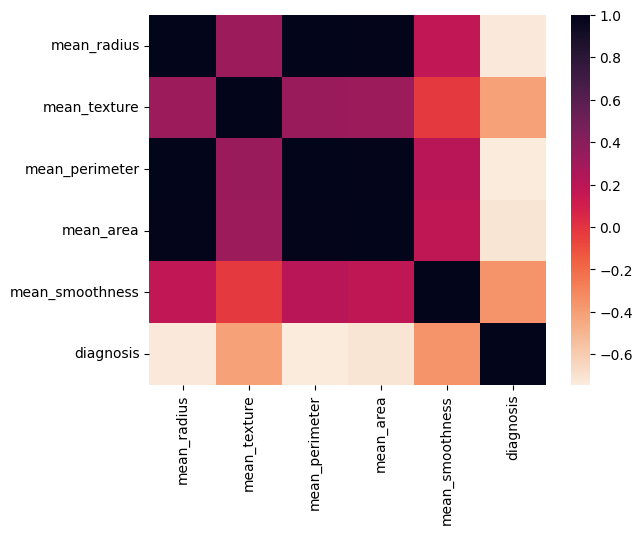

In [ ]:

import seaborn as sns
sns.heatmap(corr_mat, 
            xticklabels=numeric_cols,
            yticklabels=numeric_cols,
            cmap=sns.cm.rocket_r
           )
     

In [ ]:
display(df)

DataFrame[mean_radius: double, mean_texture: double, mean_perimeter: double, mean_area: double, mean_smoothness: double, diagnosis: int]

In [ ]:
df.write.csv("/content/output1.csv")

In [ ]:
!pip install sqlalchemy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Visualization

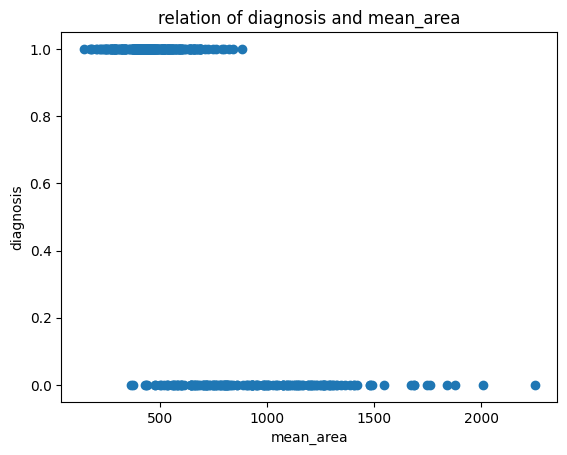

In [ ]:
import matplotlib.pyplot as plt
# taking sample of 0.8 of whole data
# convert it to pandas dataframe 
sampled_data = df.select('mean_area','diagnosis').sample(False, 0.8).toPandas()
# and at the end lets use our beautiful matplotlib
plt.scatter(sampled_data.mean_area,sampled_data.diagnosis)
plt.xlabel('mean_area')
plt.ylabel('diagnosis')
plt.title('relation of diagnosis and mean_area')
plt.show()

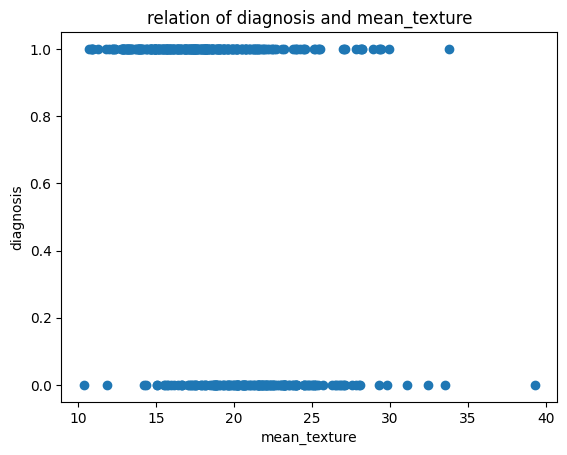

In [ ]:
import matplotlib.pyplot as plt
# taking sample of 0.8 of whole data
# convert it to pandas dataframe 
sampled_data = df.select('mean_texture','diagnosis').sample(False, 0.8).toPandas()
# and at the end lets use our beautiful matplotlib
plt.scatter(sampled_data.mean_texture,sampled_data.diagnosis)
plt.xlabel('mean_texture')
plt.ylabel('diagnosis')
plt.title('relation of diagnosis and mean_texture')
plt.show()

In [ ]:
df.rdd.getNumPartitions()

1

#Building Machine Learning Models using Pyspark.ml

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

# specify the input and output columns of the vector assembler
assembler = VectorAssembler(inputCols=['mean_radius','mean_texture', 'mean_perimeter', 'mean_area', 'mean_smoothness'],
                           outputCol='feature')


In [ ]:

from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='feature', labelCol='diagnosis')

# setup the pipeline
regression_pipeline = Pipeline(stages= [assembler,lr])

# fit the pipeline for the trainind data
model = regression_pipeline.fit(df)



In [ ]:
train_predictions = model.transform(df)


In [ ]:
test_predictions = model.transform(df)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="diagnosis", metricName="r2")

print("Train R2:", evaluator.evaluate(train_predictions))
# print("Test R2:", evaluator.evaluate(test_predictions))

Train R2: 0.6464881711839047


In [ ]:
print("Test R2:", evaluator.evaluate(test_predictions))

Test R2: 0.6464881711839047
